In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import statsmodels.api as sm
from datetime import datetime, timedelta

from sklearn.model_selection import train_test_split, cross_val_score 
from sklearn.linear_model import LinearRegression 
from sklearn.preprocessing import StandardScaler

# Initial Inspection

In [2]:
# Read in the csv file which contains data
df = pd.read_csv('kc_house_data.csv')

In [3]:
# Let's take a look at the first few columns
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [4]:
# Let's look at the data types. Note that date and sqft_basement are string object.
print(df.dtypes)
print('Dataframe shape',df.shape)

id                 int64
date              object
price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront       float64
view             float64
condition          int64
grade              int64
sqft_above         int64
sqft_basement     object
yr_built           int64
yr_renovated     float64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
dtype: object
Dataframe shape (21597, 21)


In [5]:
'''
Get the number of NAs for a DataFrame, and the percentage of NAs in the data
'''

def print_NAs(dataframe):
    for column in dataframe:
        num_nas = dataframe[column].isna().sum()
        if num_nas > 0:
            print('Found {0} \t NAs in column \t{1} ({2:0.2f}% of the data)'.format(num_nas, column, 100.*num_nas/len(df)))

print_NAs(df)

Found 2376 	 NAs in column 	waterfront (11.00% of the data)
Found 63 	 NAs in column 	view (0.29% of the data)
Found 3842 	 NAs in column 	yr_renovated (17.79% of the data)


# Plot the waterfront locations on a graph
Not shown here because of library issues but include in powerpoint

In [6]:
# From looking at the map, we found some waterfont properties labeled as NAs that had a water front view.
# Correctly assigning the NAs, requires a deeper analysis. 
# Se decided to drop this column
#df = df.drop(columns=["waterfront"])

In [7]:
# "view" column has empty values, will fill with mode
view_mode = df['view'].mode()
print(view_mode[0])
df['view'].fillna(value=view_mode[0],inplace=True)

0.0


In [8]:
# year renovated is ~18% of the data, 
#Convert year renovated to renovated or not variable
df['is_renovated'] = df['yr_renovated'].apply(lambda x: 1 if x>0 else 0)

In [9]:
#sqft basement is a string and some values are missing '?'
df['sqft_basement'].head(7) 

0       0.0
1     400.0
2       0.0
3     910.0
4       0.0
5    1530.0
6         ?
Name: sqft_basement, dtype: object

In [10]:
# the basement sqft can be calculated as the difference 
# between the living area and the above area
df['sqft_basement'] = df['sqft_living'] - df['sqft_above']
#

In [11]:
# but since sqft_basement is dependent on two other variables, lets remove it and
# let's convert it into a has basement or not
df['has_basement'] = df['sqft_basement'].apply(lambda x: 1 if x>0 else 0)


In [12]:
# Looking for outliers

In [13]:
df.bedrooms.unique()

array([ 3,  2,  4,  5,  1,  6,  7,  8,  9, 11, 10, 33])

In [14]:
df[df.bedrooms>30]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,is_renovated,has_basement
15856,2402100895,6/25/2014,640000.0,33,1.75,1620,6000,1.0,0.0,0.0,...,580,1947,0.0,98103,47.6878,-122.331,1330,4700,0,1


In [15]:
# The 33 bedroom house appears to be a typo as the property has only 1.75 bathrooms, removing..
df = df[df.bedrooms<30]

# Questions
### What is the best month / day to sell ?

In [16]:
from datetime import datetime
df['date'] = df['date'].apply(lambda x: datetime.strptime(x,'%m/%d/%Y'))


In [17]:
df['year_bought'] = df['date'].apply(lambda x: x.year)
df['month_bought'] = df['date'].apply(lambda x: x.month)
df['dofweek_bought'] = df['date'].apply(lambda x: x.weekday())

sold_per_month = df.groupby('month_bought')['price'].count()
soldm = pd.DataFrame(list(sold_per_month),columns=['Nbought'])

sold_per_week = df.groupby('dofweek_bought')['price'].count()
soldw = pd.DataFrame(list(sold_per_week),columns=['Nbought'])

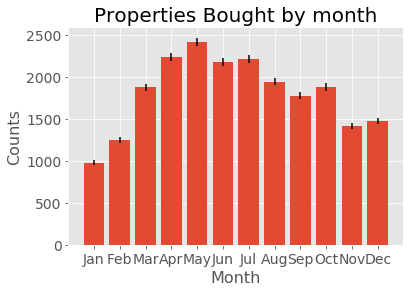

In [18]:

plt.style.use('ggplot')
month_names=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
plt.bar(soldm.index, soldm.Nbought,yerr = np.sqrt(soldm.Nbought)) 
plt.xticks(soldm.index,month_names,fontsize=14);
plt.yticks(fontsize=14);
plt.title('Properties Bought by month',fontsize=20);
plt.xlabel('Month', fontsize=16)
plt.ylabel('Counts',fontsize=16);

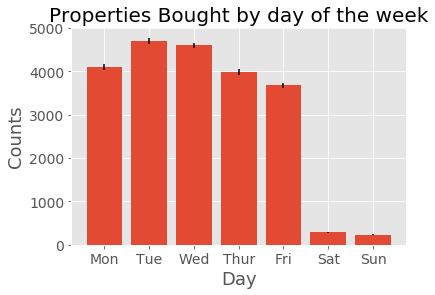

In [19]:
day_names=['Mon','Tue', 'Wed', 'Thur','Fri','Sat','Sun']
plt.bar(soldw.index, soldw.Nbought,yerr = np.sqrt(soldw.Nbought)) 
plt.xticks(soldw.index,day_names,fontsize=14);
plt.yticks(fontsize=14);
plt.title('Properties Bought by day of the week',fontsize=20);
plt.xlabel('Day', fontsize=18)
plt.ylabel('Counts',fontsize=18);

#### Most houses are sold on Tuesdays! Who is buying on a weekend?

### New/Renovated Housing vs. Price
Can how recently a house was built or renovated—it's "newness"—affect it's price per square foot?

In [20]:
df["blt_or_renov"] = df["yr_renovated"]
df.loc[df[df["blt_or_renov"] == 0].index, "blt_or_renov"] = df[df["blt_or_renov"] ==0]["yr_built"]
df["blt_or_renov"].fillna(value=df["yr_built"], inplace=True)

In [21]:
df["price_per_sqft"] = df["price"]/df["sqft_living"]

In [22]:
from statsmodels.formula.api import ols
model = ols(formula="price_per_sqft~blt_or_renov", data=df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         price_per_sqft   R-squared:                       0.065
Model:                            OLS   Adj. R-squared:                  0.065
Method:                 Least Squares   F-statistic:                     1505.
Date:                Thu, 09 May 2019   Prob (F-statistic):          2.71e-318
Time:                        13:27:56   Log-Likelihood:            -1.3143e+05
No. Observations:               21596   AIC:                         2.629e+05
Df Residuals:                   21594   BIC:                         2.629e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     2177.8484     49.337     44.142      0.000    2081.144    2274.553
blt_or_renov    -0.9700      0.025    -38.793      0.000      -1.019      -0.921
==============================================================================
Omnibus:                     4300.894   Durbin-Watson:                   1.960
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9143.552
Skew:                           1.168   Prob(JB):                         0.00
Kurtosis:                       5.170   Cond. No.                     1.35e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.35e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

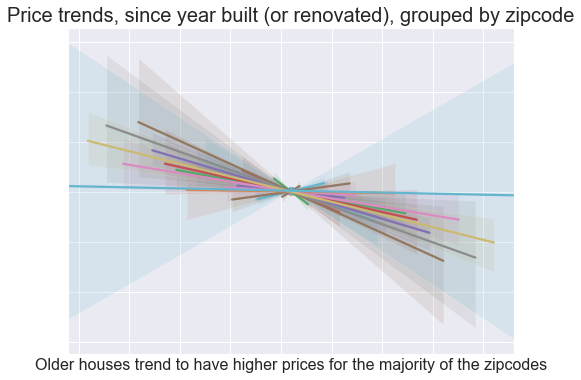

In [23]:
# Lest's fit price per sqft vs year built or renovated and show the strends per zipcode
rsquared = {}
slopes = {}

sns.set(rc={'figure.figsize':(8,6)})

for zipcode in df["zipcode"].unique():
    df_filter = df[df["zipcode"] == zipcode]
    model = ols(formula="price_per_sqft~blt_or_renov", data=df_filter).fit()
    sns.regplot("blt_or_renov","price_per_sqft", data=df_filter, label=zipcode)
    rsquared[zipcode] = model.rsquared
    slopes[zipcode] = model.params[1]

plt.title('Price trends, since year built (or renovated), grouped by zipcode', fontsize = 20)
plt.xlabel('Older houses trend to have higher prices for the majority of the zipcodes', fontsize=16)
plt.ylabel('')
plt.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)
# plt.tick_params(
#     axis='y',          # changes apply to the x-axis
#     which='both',      # both major and minor ticks are affected
#     bottom=False,      # ticks along the bottom edge are off
#     top=False,         # ticks along the top edge are off
#     left='off',
#     labelbottom=False)

In [24]:
print("Top 5 locations where new/renovated housing is cheaper than older. Near Boeing Field airport, Duvall, Renton, Kent, Delridge Except for Delridge, they are all outside downtown Seattle, with Duvall being rural.")
sorted(slopes.items(),key=lambda x:x[1])[0:5]

Top 5 locations where new/renovated housing is cheaper than older. Near Boeing Field airport, Duvall, Renton, Kent, Delridge Except for Delridge, they are all outside downtown Seattle, with Duvall being rural.


[(98075, -1.5333236003573267),
 (98072, -0.9215579923920101),
 (98177, -0.8799497903271822),
 (98019, -0.845068301698574),
 (98042, -0.815741779998186)]

In [25]:
print("The locations where new/renovated housing tends to be more expensive than older. Redmond, WA (home of Microsoft), Bellevue, Washington Park, etc..")
pos_slopes = [x[0] for x in slopes.items() if x[1] > 0]
print(pos_slopes)

The locations where new/renovated housing tends to be more expensive than older. Redmond, WA (home of Microsoft), Bellevue, Washington Park, etc..
[98053, 98007, 98112, 98027, 98166, 98070, 98008, 98144, 98034, 98102, 98029]


Taking a look at the relationship for the zipcode with the largest correlation - 98019.


Text(0.5, 1.0, 'Price per sq.ft. vs year  for zipcode 98019')

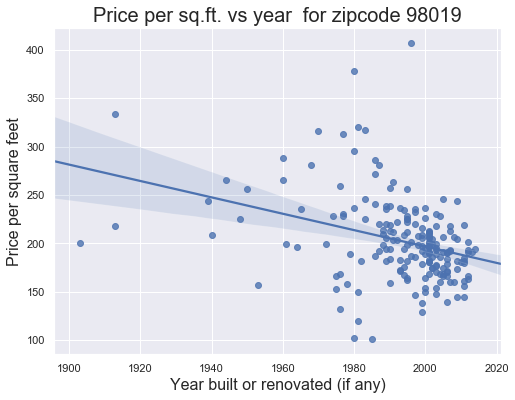

In [26]:
print("Taking a look at the relationship for the zipcode with the largest correlation - 98019.")
sns.regplot("blt_or_renov","price_per_sqft", data=df[df["zipcode"] == 98019], label=zipcode)

plt.xlabel('Year built or renovated (if any)',fontsize=16 )
plt.ylabel('Price per square feet',fontsize=16 )
plt.title('Price per sq.ft. vs year  for zipcode 98019',fontsize=20 )

Maybe we can ignore pre-1980 housing as there's not much and they appear to be outliers


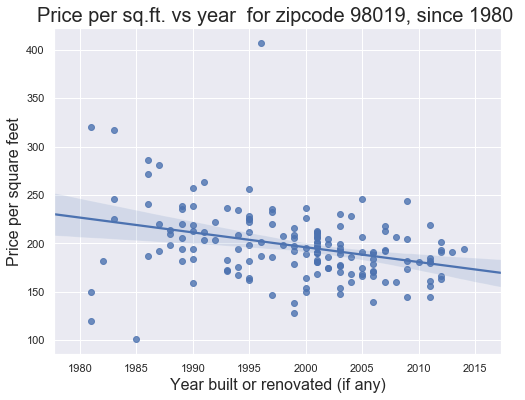

In [27]:
print("Maybe we can ignore pre-1980 housing as there's not much and they appear to be outliers");
sns.regplot("blt_or_renov","price_per_sqft", data=df[(df["zipcode"] == 98019) & (df["blt_or_renov"] >1980)], label=zipcode)

plt.xlabel('Year built or renovated (if any)',fontsize=16 );
plt.ylabel('Price per square feet',fontsize=16 );
plt.title('Price per sq.ft. vs year  for zipcode 98019, since 1980 ',fontsize=20 );

Not a very predictive model but confidence interval bolsters the idea that price per square foot is declining for newer housing in certain zip codes.

## Modelling whole data set

In [28]:
columns_to_drop = ['id', 'date']
#columns_to_drop = ['id', 'zipcode','lat','long',\
#                   'date', 'sqft_basement' , 'yr_renovated','price_per_sqft', 'blt_or_renov']
# We are removing these columns as the seller is not is control of this variables


In [29]:
df.drop(columns_to_drop, axis=1, inplace=True)

In [30]:
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,long,sqft_living15,sqft_lot15,is_renovated,has_basement,year_bought,month_bought,dofweek_bought,blt_or_renov,price_per_sqft
0,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,3,7,...,-122.257,1340,5650,0,0,2014,10,0,1955.0,188.050847
1,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3,7,...,-122.319,1690,7639,1,1,2014,12,1,1991.0,209.338521
2,180000.0,2,1.00,770,10000,1.0,0.0,0.0,3,6,...,-122.233,2720,8062,0,0,2015,2,2,1933.0,233.766234
3,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,5,7,...,-122.393,1360,5000,0,1,2014,12,1,1965.0,308.163265
4,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,3,8,...,-122.045,1800,7503,0,0,2015,2,2,1987.0,303.571429


In [32]:
# Dropping additional columns
# year_bought is all effectively 2014 and 2015. 
# sqft_living15 and sqft_lot15 only has correlations to sqft, 
# which is a more representative variable
#more_cols_to_drop = ['year_bought', 'sqft_lot15', 'sqft_living15']

In [33]:
#df.drop(more_cols_to_drop, axis=1, inplace=True)

# Standardize the data

In [34]:
b = df['sqft_living']
sqft_living_min = min(b)
sqft_living_range = max(b)-min(b)
df['sqft_living'] = (b-sqft_living_min)/sqft_living_range

b = df['sqft_above']
sqft_ab_min = min(b)
sqft_ab_range = max(b)-min(b)
df['sqft_above'] = (b-sqft_ab_min)/(sqft_ab_range)

b = df['sqft_lot']
sqft_lot_min = min(b)
sqft_lot_range = max(b)-min(b)
df['sqft_lot'] = (b-sqft_lot_min)/(sqft_lot_range)

b = df['sqft_living15']
sqft_living15_min = min(b)
sqft_living15_range = max(b)-min(b)
df['sqft_living15'] = (b-sqft_living15_min)/sqft_living15_range

b = df['sqft_lot15']
sqft_lot15_min = min(b)
sqft_lot15_range = max(b)-min(b)
df['sqft_lot15'] = (b-sqft_lot15_min)/sqft_lot15_range

b = df['sqft_basement']
sqft_basement_min = min(b)
sqft_basement_range = max(b)-min(b)
df['sqft_basement'] = (b-sqft_basement_min)/sqft_basement_range

b = df['yr_built']                  
yb_min = min(b)
yb_range = max(b)-min(b)
df['yr_built'] = (b-yb_min)/(yb_range)

b = df['yr_renovated']                  
yb_min = min(b)
yb_range = max(b)-min(b)
df['yr_renovated'] = (b-yb_min)/(yb_range)

# standardization
b = df['price']
y = np.log(b)
# price_mean = b.mean()
# price_std = b.std()
# y = (b-price_mean)/(price_std)


In [35]:
zip_dummy = pd.get_dummies(df["zipcode"], prefix="ZIP")
df = df.drop(columns=["zipcode"],)
df = pd.concat([df, zip_dummy], axis=1)
df.drop(df.columns[-1], axis=1, inplace=True)

In [36]:
wf_dummy = pd.get_dummies(df["waterfront"], prefix="WF")
df = df.drop(columns=["waterfront"],)
df = pd.concat([df, wf_dummy], axis=1)

In [37]:
view_dummy = pd.get_dummies(df["view"], prefix="VIEW")
df = df.drop(columns=["view"],)
df = pd.concat([df, view_dummy], axis=1)
df.drop(df.columns[-1], axis=1, inplace=True)

In [38]:
condition_dummy = pd.get_dummies(df["condition"], prefix="COND")
df = df.drop(columns=["condition"],)
df = pd.concat([df, condition_dummy], axis=1)
df.drop(df.columns[-1], axis=1, inplace=True)

In [39]:
grade_dummy = pd.get_dummies(df["grade"], prefix="GRADE")
df = df.drop(columns=["grade"],)
df = pd.concat([df, grade_dummy], axis=1)
df.drop(df.columns[-1], axis=1, inplace=True)

In [40]:
print_NAs(df)

Found 3842 	 NAs in column 	yr_renovated (17.79% of the data)


In [41]:
df.drop("yr_renovated", axis=1, inplace=True)

In [42]:
#from sklearn.cluster import SpectralClustering
#model = SpectralClustering(n_clusters=10, affinity='nearest_neighbors',
#                           assign_labels='kmeans')
#labels = model.fit_predict(X)

In [43]:
#Lets select our predictor data frame
X = df.drop(columns=['price', "price_per_sqft"])

In [44]:
# Let's split the data into train and test data sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
print('Train length ',len(X_train), len(y_train))
print('Test length ',len(X_test), len(y_test))

Train length  17276 17276
Test length  4320 4320


In [45]:
from sklearn.linear_model import Ridge
linreg = Ridge(alpha=.5)
linreg.fit(X_train, y_train)
#model = sm.OLS(y_train, sm.add_constant(X_train[fields])).fit()
#model = sm.OLS(y_train, sm.add_constant(X_train)).fit()

Ridge(alpha=0.5, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [46]:
linreg.score(X_train, y_train)

0.8817410198834189

In [47]:
from sklearn.metrics import r2_score
y_predict = linreg.predict(X_test)

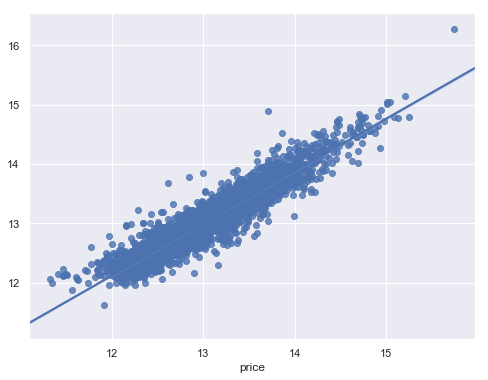

In [48]:
sns.regplot(y_test, y_predict)

In [49]:
r2_score(y_predict, y_test)

0.8657880742858199

In [50]:
y_predict_train = linreg.predict(X_train)
print(r2_score(y_predict_train, y_train))
print(r2_score(y_predict, y_test))

0.8654734057482925
0.8657880742858199


In [52]:
from sklearn.metrics import mean_squared_error
train_mse = mean_squared_error(y_train, y_predict_train)
test_mse = mean_squared_error(y_test, y_predict)
print('Train Mean Squarred Error:', train_mse)
print('Test Mean Squarred Error:', test_mse)
print(test_mse/train_mse)

Train Mean Squarred Error: 0.03269765840439432
Test Mean Squarred Error: 0.03314080476319319
1.0135528469139343
